In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
#https://drive.google.com/file/d/15vtzJuiI-3POTLUYp87-ZKUESFJApglc/view?usp=sharing
#https://drive.google.com/file/d/1R_mIMy-Yyvkok3XzsLRkEBcRjsTD-On4/view?usp=sharing  
#https://drive.google.com/file/d/1m3X_hg0aZVVJF_BnqXKIY96d-3qyNBRh/view?usp=sharing   Corregido
!gdown --id "1R_mIMy-Yyvkok3XzsLRkEBcRjsTD-On4"
!gdown --id "1m3X_hg0aZVVJF_BnqXKIY96d-3qyNBRh"
#https://drive.google.com/file/d/1cfpRsiMjECwbrSdvcOQd-25T5NCPpgcu/view?usp=sharing
#https://drive.google.com/file/d/1dRa9wYTOy8SfynivnVpLIR5_Tx3Z4oa6/view?usp=sharing
#https://drive.google.com/file/d/1Q694dPk7a7BjIAJjP3g_G9H0RTDuB_xl/view?usp=sharing
!gdown --id "1cfpRsiMjECwbrSdvcOQd-25T5NCPpgcu"
!gdown --id "1dRa9wYTOy8SfynivnVpLIR5_Tx3Z4oa6"
!gdown --id "1Q694dPk7a7BjIAJjP3g_G9H0RTDuB_xl"

Downloading...
From: https://drive.google.com/uc?id=1R_mIMy-Yyvkok3XzsLRkEBcRjsTD-On4
To: /content/Motor_Monofasico_2_2.csv
100% 116k/116k [00:00<00:00, 44.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1m3X_hg0aZVVJF_BnqXKIY96d-3qyNBRh
To: /content/Motor_Monofasico_2_2_rms.csv
100% 107k/107k [00:00<00:00, 31.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cfpRsiMjECwbrSdvcOQd-25T5NCPpgcu
To: /content/Motor_trifasico_Para_entrenamiento.csv
100% 118k/118k [00:00<00:00, 43.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dRa9wYTOy8SfynivnVpLIR5_Tx3Z4oa6
To: /content/Motor_trifasico_Para_Prediccion.csv
100% 15.3k/15.3k [00:00<00:00, 22.5MB/s]


In [2]:
def graficar_resultado(Valor_real, Valor_prediccion):
    plt.figure(figsize=(32,15))
    plt.plot(Valor_real[0:len(Valor_prediccion)],color='red', label='Dato Real del sensor')
    plt.plot(Valor_prediccion, color='blue', label='Dato predicho')
   # plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor V en m/s2')
    plt.legend()
    plt.show()

In [3]:
#
# Lectura de los datos
#
dataset = pd.read_csv('datos_para_entrenamiento_3.csv', index_col='Datos_fch_hr', parse_dates=['Datos_fch_hr'])
dataset.head()


,Datos_eje_x,Datos_eje_y,Datos_eje_z
Datos_fch_hr,,,
2021-01-01 01:22:54,-0.05,3.48,-0.10
2021-01-01 01:22:55,-0.09,2.45,-1.04
2021-01-01 01:22:56,0.99,0.01,-7.74
2021-01-01 01:22:57,0.36,2.26,-2.39
2021-01-01 01:22:58,0.39,2.05,-1.62


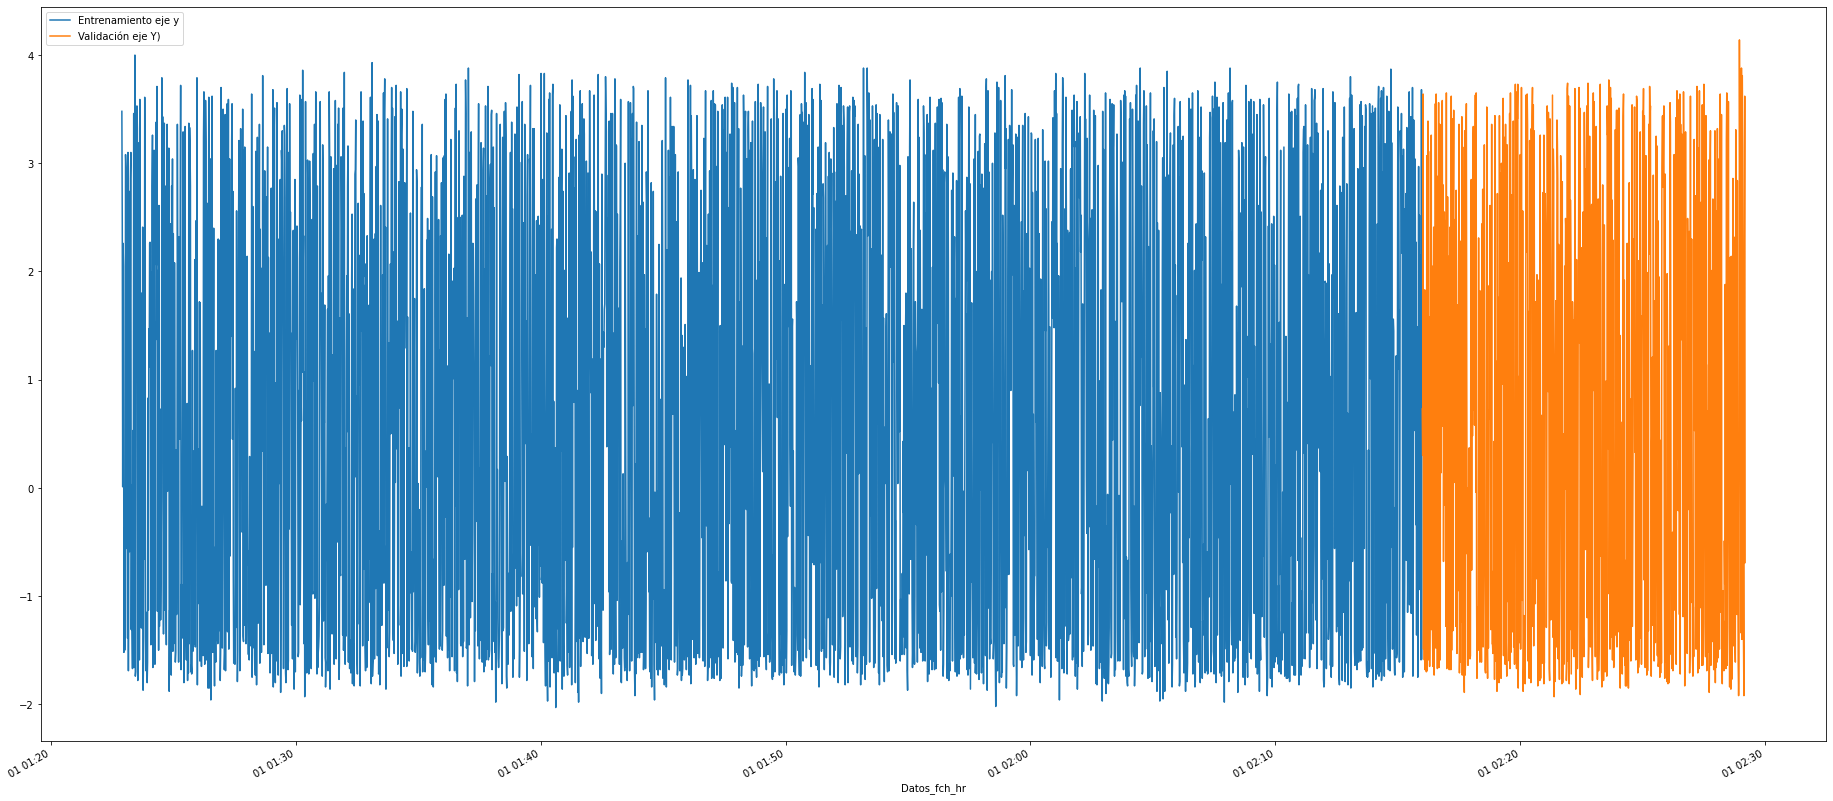

In [5]:

#
# DAtos de validacion y entrenamiento
# La LSTM se entrenaria con los datos provenientes de la base de datos 
# Es un entrenamiento / dataset, para cada sensor
#
set_entrenamiento_sensor = dataset[:'2021-01-01 2:15:59'].iloc[:,1:2]
set_validacion_sensor = dataset['2021-01-01 2:16:00':].iloc[:,1:2]
plt.figure(figsize=(32,15))
set_entrenamiento_sensor['Datos_eje_y'].plot(legend=True)
set_validacion_sensor['Datos_eje_y'].plot(legend=True)

plt.legend(['Entrenamiento eje y', 'Validación eje Y)'])
plt.show()

# Se normalizan los datos para la lstm
sc = MinMaxScaler(feature_range=(-1,1))
set_entrenamiento_sensor_escalado = sc.fit_transform(set_entrenamiento_sensor)

In [6]:
set_validacion_sensor.head()

,Datos_eje_y
Datos_fch_hr,
2021-01-01 02:16:00,0.73
2021-01-01 02:16:01,0.30
2021-01-01 02:16:02,3.64
2021-01-01 02:16:03,-1.49
2021-01-01 02:16:04,-0.62


In [7]:

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 30
X_train = []
Y_train = []
m = len(set_entrenamiento_sensor_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_sensor_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_sensor_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:

#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 32
inicio = int(round(time.time() * 1000))

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
#modelo.compile(optimizer='rmsprop', loss='mse')
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=400,batch_size=16)

fin = int(round(time.time() * 1000))
print(inicio,fin)

Epoch 1/400
3172/3172 [==============================] - 1s 471us/step - loss: 0.4184
Epoch 2/400
3172/3172 [==============================] - 1s 370us/step - loss: 0.4172
Epoch 3/400
3172/3172 [==============================] - 1s 364us/step - loss: 0.4156
Epoch 4/400
3172/3172 [==============================] - 1s 361us/step - loss: 0.4151
Epoch 5/400
3172/3172 [==============================] - 1s 362us/step - loss: 0.4154
Epoch 6/400
3172/3172 [==============================] - 1s 360us/step - loss: 0.4153
Epoch 7/400
3172/3172 [==============================] - 1s 361us/step - loss: 0.4152
Epoch 8/400
3172/3172 [==============================] - 1s 361us/step - loss: 0.4142
Epoch 9/400
3172/3172 [==============================] - 1s 356us/step - loss: 0.4139
Epoch 10/400
3172/3172 [==============================] - 1s 360us/step - loss: 0.4135
Epoch 11/400
3172/3172 [==============================] - 1s 358us/step - loss: 0.4132
Epoch 12/400
3172/3172 [============================

3172/3172 [==============================] - 1s 368us/step - loss: 0.2133
Epoch 189/400
3172/3172 [==============================] - 1s 383us/step - loss: 0.2103
Epoch 190/400
3172/3172 [==============================] - 1s 372us/step - loss: 0.2078
Epoch 191/400
3172/3172 [==============================] - 1s 367us/step - loss: 0.2067
Epoch 192/400
3172/3172 [==============================] - 1s 363us/step - loss: 0.2062
Epoch 193/400
3172/3172 [==============================] - 1s 380us/step - loss: 0.2061
Epoch 194/400
3172/3172 [==============================] - 1s 378us/step - loss: 0.2011
Epoch 195/400
3172/3172 [==============================] - 1s 360us/step - loss: 0.1993
Epoch 196/400
3172/3172 [==============================] - 1s 374us/step - loss: 0.2009
Epoch 197/400
3172/3172 [==============================] - 1s 359us/step - loss: 0.1984
Epoch 198/400
3172/3172 [==============================] - 1s 360us/step - loss: 0.1963
Epoch 199/400
3172/3172 [=====================

3172/3172 [==============================] - 1s 457us/step - loss: 0.1159
Epoch 282/400
3172/3172 [==============================] - 1s 406us/step - loss: 0.1115
Epoch 283/400
3172/3172 [==============================] - 2s 482us/step - loss: 0.1134
Epoch 284/400
3172/3172 [==============================] - 1s 374us/step - loss: 0.1124
Epoch 285/400
3172/3172 [==============================] - 1s 357us/step - loss: 0.1094
Epoch 286/400
3172/3172 [==============================] - 1s 360us/step - loss: 0.1090
Epoch 287/400
3172/3172 [==============================] - 1s 359us/step - loss: 0.1079
Epoch 288/400
3172/3172 [==============================] - 1s 360us/step - loss: 0.1086
Epoch 289/400
3172/3172 [==============================] - 1s 361us/step - loss: 0.1066
Epoch 290/400
3172/3172 [==============================] - 1s 377us/step - loss: 0.1049
Epoch 291/400
3172/3172 [==============================] - 1s 439us/step - loss: 0.1069
Epoch 292/400
3172/3172 [=====================

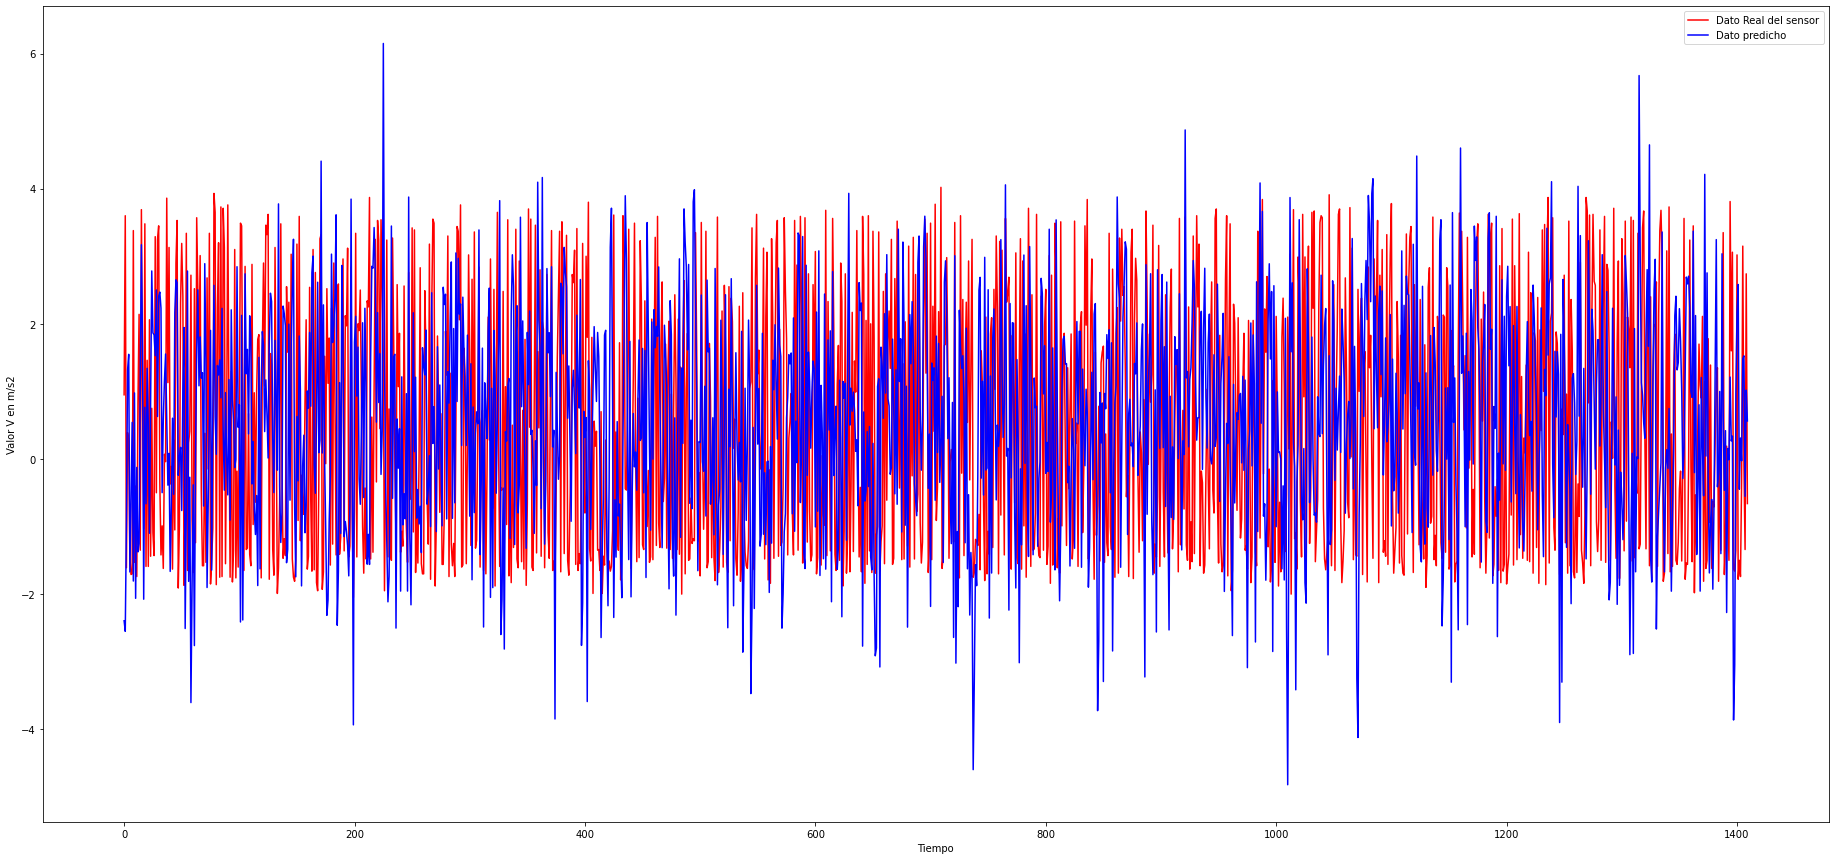

In [26]:

#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion_sensor.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_resultado(set_validacion_sensor.values,prediccion)

In [27]:
#Sacar informacion de los graficos , Vs los resultados
np.savetxt("Datos_reales_exp_2_2.txt", set_validacion_sensor.values,fmt="%.5f", delimiter=",", newline="\n")
np.savetxt("Datos_predichos_exp_2_2.txt", prediccion,fmt="%.5f", delimiter=",", newline="\n")